# Проект по анализу данных о ближайших к Земле астероидов
## Выполнил Земнухов В.Т.
### Группа DS-10

# Содержание
[**Определение основных характеристик астероидов, влияющих на их степень угрозы жизни на Земле при столкновении**](#id_1)

[**Проверка возможности наблюдать за опасными астероидами через любительский телескоп**](#id_2)

[**Расчет максимально возможной скорости исследовательского аппарата на поверхности астерода**](#id_3)

[**Выводы**](#id_4)

<img src="img/asteroid.jpeg">

<div id= 'id_1'/>

# Определение основных характеристик астероидов, влияющих на их степень угрозы жизни на Земле при столкновении

Для проекта по анализу данных возьмём Dataset, составленный космическим агенством NASA, содержащий информацию о ближайших к Земле астероидах, с источника https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects 

По полученной информации установим, как по мнению NASA влияют характеристики астероида на факт угрозы жизни на Земле при гипотетическом столкновении, и оценим возможность наблюдать данные космические тела через любительский телескоп. Также в качестве перспективы на будущее рассчитаем приблизительную скорость (первая космическая скорость), которую научно-исследовательскому аппарату нельзя превышать на поверхности астероида для того, чтобы не оторваться от его поверхности с последующим вращением вокруг него в качестве спутника.

In [1]:
#импортируем библиотеку pandas и содадим DataFrame
import pandas as pd

df = pd.read_excel('neo_v2.xlsx')

In [2]:
#Проверим, что получилось создать DataFrame
df.head(10)

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True
5,54138696,(2021 GY23),0.036354,0.081291,34297.587778,4.058569e+07,Earth,False,24.32,False
6,54189957,(2021 PY40),0.171615,0.383743,27529.472307,2.906912e+07,Earth,False,20.95,False
7,54230078,(2021 XD6),0.005328,0.011914,57544.470083,5.511502e+07,Earth,False,28.49,False
8,2088213,88213 (2001 AF2),0.350393,0.783502,56625.210122,6.903598e+07,Earth,False,19.40,False
9,3766065,(2016 YM),0.105817,0.236614,48425.840329,3.835526e+07,Earth,False,22.00,False


In [3]:
#Проверим количество данных в DataFrame
df.shape

(90836, 10)

Как можно заметить DataFrame содержит большое количество данных, поэтому для более быстрых расчетов с использованием числовых значений из таблицы будем использовать библиотеку numpy.

In [4]:
#Узнаем типы данных в нашем DataFrame и количество пропусков.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


Обнаруживаем, что типы данных соответсвуют ожидаемым, а также что в нашем DataFrame нет пропусков, т. к. число "не нулевых" значений для всех колонок совпадает с общим числом всех строк.

In [5]:
#Проверим, что все id астероидов уникальные, и нет повторений
len(df['id'].unique())

27423

In [6]:
#Проверим что количество уникальных id и names совпадают
len(df['id'].unique()) == len(df['name'].unique())

True

In [7]:
#проверим количество элементов при отбросе дубликатов
len(df.drop('id', axis=1).drop_duplicates())

90836

Можем заметить, что не отбросился ни 1 элемент. Связано это с тем, что для одного и того же астероида были несколько раз внесены данные в таблицу в связи с изменением его расстояния и скорости относительно Земли. Остальные данные (размеры, яркость), как правило, являются приблизительными рассчетными величинами, и если и вносятся какие-либо корректировки, то они не значительные. Тем не менее в данном случае более корректно использовать средние значения величин для повторяющихся элементов Dataset, которые будут рассчитаны по значениям для каждого астероида.

Для выполнения данных операций будем применять метод группировки, но для начала определим, какие данные нам не потребуются для дальнейшего анализа.

In [8]:
#Проверим количество уникальных значений в колонках 'orbiting_body' (ближайшая планета) и 
#'sentry_object' (в этой колонке значения True могут встретиться для тех астероидов, которые входят в состав 
#автоматизированной системы мониторинга столкновений)

df['orbiting_body'].unique()

array(['Earth'], dtype=object)

Обнаруживаем, что все значения в столбце 'orbiting_body' одинаковые, следовательно данный Dataset составлен только для ближайших астероидов к платене Земля, поэтому данный столбец для дальнейшего анализа данных нам не понадобиться.

In [9]:
df['sentry_object'].unique()

array([False])

Можем сделать вывод, что ни 1 из самых ближайших метеоритов к планете Земля не включен в систему мониторинга столкновений sentry. Отсюда можем сделать 2 вывода:

1. Либо нам ничего не угрожает в ближайшее время, и мы можем спать спокойно, либо мы на сегодняшний день знаем недостаточно о возможных космических угрозах. Каждый для себя решит, сам во что больше хочется верить;


2. Колонка 'sentry_object' не нужна для дальнейшего анализа данных

Колонка 'id' также не несет в себе никакой полезной информации для нашего анализа, поэтому её тоже можно убрать. Итого, нам нужно убрать из нашего DataFrame колонки 'id', 'sentry_object', 'orbiting_body'.

In [10]:
df = df.drop(['id','sentry_object','orbiting_body'], axis = 1)

Для удобства восприятия переименуем наши колонки на русский язык. 

Так как астероиды чаще всего имеют неправильную форму, для удобства расчетов принято делать допущение, что форма астероида эллипсоидная. В случае с колонками 'est_diameter_min' и 'est_diameter_max' речь идёт о приблизительных значениям малой и большой оси эллипсоида вращения. Так и назовем эти колонки. Числовые значения в данных колонках имеют размерность - км.

В случае с названием колонки 'relative_velocity' речь идёт о скорости астероида относительно Земли в м/с.

'miss_distance' - это среднее расстояние от Земли до астероида в км.

'absolute_magnitude' - значение видимой яркости или видимой звездной величины астероида.  Данная величина характеризует возможность увидеть небесное тело с Земли. Не имеет размерности и обозначается буквой m. Для того, чтобы отличать от массы, назовем колонку 'Видимая яркость'

'hazardous' - опасность для жизни при гипотетическом падении. Назовём эту колонку 'Гиппотетич. опасность'

In [11]:
df.rename(columns = {'name' : 'Название', 'est_diameter_min' : 'Малая ось, км', 'est_diameter_max' : 'Большая ось, км', 'relative_velocity' : 'Скорость отн. Земли, м/с', 'absolute_magnitude' : 'Видимая яркость', 'miss_distance' : 'Расстояние до Земли, км', 'hazardous' :  'Гиппотетич. опасность'}, inplace = True)

In [12]:
df_groupped = df.groupby(['Название'])['Гиппотетич. опасность','Малая ось, км', 'Большая ось, км', 'Скорость отн. Земли, м/с', 'Расстояние до Земли, км', 'Видимая яркость'].mean()
df_groupped

C:\Users\79629\AppData\Local\Temp\ipykernel_6028\2456713686.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_groupped = df.groupby(['Название'])['Гиппотетич. опасность','Малая ось, км', 'Большая ось, км', 'Скорость отн. Земли, м/с', 'Расстояние до Земли, км', 'Видимая яркость'].mean()


,Гиппотетич. опасность,"Малая ось, км","Большая ось, км","Скорость отн. Земли, м/с","Расстояние до Земли, км",Видимая яркость
Название,,,,,,
(1983 LC),1.0,0.342417,0.765667,60192.646491,1.847664e+07,19.45
(1986 NA),0.0,0.284810,0.636854,51810.077045,7.005246e+07,19.85
(1988 NE),0.0,0.402305,0.899580,22815.738845,6.506331e+07,19.10
(1989 AZ),0.0,0.319562,0.714562,55184.046572,2.560466e+07,19.60
(1991 GO),1.0,0.265800,0.594347,92501.896829,3.695728e+07,20.00
...,...,...,...,...,...,...
9950 ESA (1990 VB),0.0,1.522492,3.404395,29511.503126,6.272026e+07,16.21
99799 (2002 LJ3),0.0,0.563060,1.259041,28970.538534,4.643519e+07,18.37
99907 (1989 VA),0.0,0.689533,1.541842,79729.216475,4.056173e+07,17.93


In [13]:
#Проверим равно ли количество уникальных 'id' в исходном DataFrame и в сгурппированном
len(df_groupped) == len(df['Название'].unique())

True

Обращаем внимание на то, что булевые переменные в колонке 'Гиппотетич. опасность' преобразовались в тип данных float.

In [14]:
#Проверим, что все значения в этой колонке являются либо 1.0, либо 0.0
len(df_groupped[(df_groupped['Гиппотетич. опасность'] == 0.0) | ((df_groupped['Гиппотетич. опасность'] == 1.0))]) == len(df_groupped)

True

In [15]:
#Преобразуем значения в колонке 'Гиппотетич. опасность' снова в булевый тип данных и проверим, что при данных преобразованиях
#всё выполнилось корректно
true_check = len(df_groupped[(df_groupped['Гиппотетич. опасность'] == 1.0)])
false_check = len(df_groupped[(df_groupped['Гиппотетич. опасность'] == 0.0)])
df_groupped['Гиппотетич. опасность'] = df_groupped['Гиппотетич. опасность'].astype('bool')
print(len(df_groupped[df_groupped['Гиппотетич. опасность'] == True]) == true_check)
print(len(df_groupped[df_groupped['Гиппотетич. опасность'] == False]) == false_check)

True
True


Делаем вывод, что в ходе группировки и дальнейшего преобразования булевые переменные остались корректными для каждого астероида

In [16]:
#ещё раз проверим наличие пустых значений
df_groupped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27423 entries, (1983 LC) to 99942 Apophis (2004 MN4)
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Гиппотетич. опасность     27423 non-null  bool   
 1   Малая ось, км             27423 non-null  float64
 2   Большая ось, км           27423 non-null  float64
 3   Скорость отн. Земли, м/с  27423 non-null  float64
 4   Расстояние до Земли, км   27423 non-null  float64
 5   Видимая яркость           27423 non-null  float64
dtypes: bool(1), float64(5)
memory usage: 1.3+ MB


Вычислим объем астероидов путем нахождения объема эллипсоида вращения по формуле: $$V = \frac{4}{3} \pi a b^2,$$ где a - малая полуось эллипса, b - большая полуось эллипса.

In [17]:
#учтем, что км^3 нужно перевести в м^3

import numpy as np
from math import pi as pi

df_groupped['V, м^3'] = ((4 / 3) * pi * (np.array(df_groupped['Малая ось, км'])/2) * (np.array(df_groupped['Большая ось, км'])/2) ** 2) * (1000**3)

Для того, чтобы посчитать массу астероида, необходимо объем астероида умножить на его плотность. На сегодняшний день узнать точное значение плотности данного небесного тела достаточно затруднительно. Долгое время было принято считать среднюю плотность астероидов 2 $г/см^3$. Данное значение было получено в результате исследований метеоритов, упавших на Землю. Тем не менее последние теоретические расчеты показывают, что плотность астероидов может быть от 1,38 $г/см^3$ до 5,32 $г/см^3$. Как мы видим, минимальное и максимальное теоретическое значение плотности отличаются от ранее принятого среднего значения 2 $г/см^3$. Поэтому более правильно будет рассчитать теоретическую минимальную и максимальную массы астероида.

Воспользуемся формулой: $$m = \rho V$$

In [18]:
#Для расчета массы необходимо учесть, что г/см^3 необходимо перевести в кг/м^3
df_groupped['m min, кг'] = df_groupped['V, м^3'].apply(lambda x: x * (1.38*(100**3)/1000))
df_groupped['m max, кг'] = df_groupped['V, м^3'].apply(lambda x: x * (5.32*(100**3)/1000))

Теперь можем выдвинуть предположение о том, чем руководствуется NASA при определении астероида, как угрожающего.

Предположим, что астероиды с большими значениями кинетической энергии являются более опасными и имеют значение 'True' в колонке 'Гиппотетич. опасность'. Рассчитаем значения кинетической энергии для каждого астероида, отсортируем наш DataFrame по этому значению по убыванию, чтобы понять этим ли параметром руководствуется NASA или учитывает ещё и другие. Если предположение верно, то таблица начнется с опасных астероидов. 

Для расчета кинетической энергии будем использовать значение максимально возможной массы, чтобы учесть наихудший вариант развития событий.

Воспользуемся формулой: $$E_{к} = \frac{mv^2}{2}$$

In [19]:
df_groupped['Eк max, Дж'] = np.array(df_groupped['m max, кг']) * (np.array(df_groupped['Скорость отн. Земли, м/с']) ** 2) / 2

In [20]:
df_groupped.sort_values('Eк max, Дж', ascending = False).head(30)

,Гиппотетич. опасность,"Малая ось, км","Большая ось, км","Скорость отн. Земли, м/с","Расстояние до Земли, км",Видимая яркость,"V, м^3","m min, кг","m max, кг","Eк max, Дж"
Название,,,,,,,,,,
1036 Ganymed (A924 UB),False,37.892650,84.730541,51496.923293,5.372124e+07,9.23,1.424405e+14,1.965679e+17,7.577836e+17,1.004796e+27
1866 Sisyphus (1972 XA),False,8.640820,19.321462,91462.394087,7.070096e+07,12.44,1.689015e+12,2.330841e+15,8.985561e+15,3.758377e+25
433 Eros (A898 PA),False,23.043847,51.527608,19682.887099,3.754117e+07,10.31,3.203565e+13,4.420920e+16,1.704297e+17,3.301359e+25
2212 Hephaistos (1978 SB),False,5.230642,11.696071,107246.722929,5.921903e+07,13.53,3.746567e+11,5.170263e+14,1.993174e+15,1.146260e+25
16960 (1998 QS52),True,3.439973,7.692012,126572.996861,4.636098e+07,14.44,1.065697e+11,1.470661e+14,5.669506e+14,4.541479e+24
3200 Phaethon (1983 TB),True,3.503926,7.835018,117420.653140,2.952194e+07,14.40,1.126247e+11,1.554221e+14,5.991633e+14,4.130515e+24
1627 Ivar (1929 SH),False,7.456843,16.674007,37715.974055,4.529595e+07,12.76,1.085509e+12,1.498003e+15,5.774910e+15,4.107389e+24
20826 (2000 UV13),False,4.534767,10.140047,79031.687594,5.041168e+07,13.84,2.441370e+11,3.369090e+14,1.298809e+15,4.056185e+24
4954 Eric (1990 SQ),False,8.101305,18.115068,32852.598792,4.286086e+07,12.58,1.391982e+12,1.920935e+15,7.405343e+15,3.996268e+24


Исходя из полученных данных делаем вывод, что помимо кинетической энергии учитываются также и другие факторы, не указанные в данном Dataset, например химический состав астероида, наиболее вероятная траектория падения и др. 

Тем не менее параметр кинетической энергии является одним из наиболее важных в данном анализе. Проверим статистические параметры этой величины для астероидов со значением False и True в колонке 'Гиппотетич. опасность'

In [21]:
df_groupped[df_groupped['Гиппотетич. опасность'] == True]['Eк max, Дж'].describe()

count    2.173000e+03
mean     1.556031e+22
std      1.645112e+23
min      5.547291e+18
25%      7.394393e+19
50%      2.622867e+20
75%      1.371001e+21
max      4.541479e+24
Name: Eк max, Дж, dtype: float64

In [22]:
df_groupped[df_groupped['Гиппотетич. опасность'] == False]['Eк max, Дж'].describe()

count    2.525000e+04
mean     4.739289e+22
std      6.332005e+24
min      1.111670e+12
25%      6.306677e+16
50%      7.790306e+17
75%      2.077761e+19
max      1.004796e+27
Name: Eк max, Дж, dtype: float64

Исходя из статистики выше для значений кинетической энергии, видно, что медиана, а также первый и третий квантиль для опасных астероидов на несколько порядков выше, чем для неопасных. Также можно заметить, что минимальное значение данной физической величины для первых на 6 порядков выше, чем минимальное значение для вторых.

Тем не менее мы видим, что максимальное значение для неопасных всё-таки выше, чем для опасных, отсюда можно сделать вывод, что NASA учитывает параметр кинетической энергии, но при этом он не является единственным, хоть и значительно влияющим.

Сравнивать средние значения в данном случае не очень корректно, т. к. существует достаточно большой разброс данных между минимальным и максимальным значениями.

Построим столбчатую диаграмму для значений медиан.

In [45]:
from matplotlib import pyplot as plt

Text(0.5, 1.0, 'Медиана Ек')

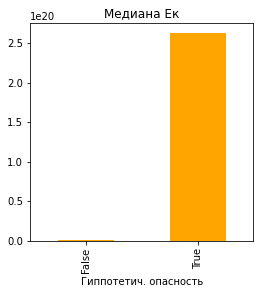

In [46]:
fig_med, ax = plt.subplots(1, 1, figsize=(4, 4))

df_groupped.groupby('Гиппотетич. опасность')['Eк max, Дж'].median().plot(kind='bar', color = 'orange');

ax.set_title('Медиана Ек')

In [47]:
#Проверим значения моды.
true_mode = df_groupped[df_groupped['Гиппотетич. опасность'] == True]['Eк max, Дж'].mode()
true_mode

0    2.634763e+19
Name: Eк max, Дж, dtype: float64

In [48]:
df_groupped[df_groupped['Гиппотетич. опасность'] == False]['Eк max, Дж'].mode()

0        1.111670e+12
1        4.944398e+12
2        5.063636e+12
3        5.484468e+12
4        8.020338e+12
             ...     
25245    4.107389e+24
25246    1.146260e+25
25247    3.301359e+25
25248    3.758377e+25
25249    1.004796e+27
Name: Eк max, Дж, Length: 25250, dtype: float64

Исходя из значений моды можно сделать вывод, что для опасных астероидов наиболее часто встречаются те, значения кинетической энергии которых достаточно высокое. У не опасных в то же время очень большой разброс значений моды. Для первого случая мы получили всего 1 значение моды, для второго количество значений моды близко к значению общего количества элементов отфильтрованного Dataset. В связи с этим сравнивать средние значения моды будет не корректно из-за сильно разного размера 2 выборок, а также из-за большого разброса значений моды для неопасных астероидов.

In [49]:
E_check = df_groupped[df_groupped['Гиппотетич. опасность'] == False]
(E_check['Eк max, Дж'] < true_mode[0]).value_counts()

True     19304
False     5946
Name: Eк max, Дж, dtype: int64

Как можно заметить неопасных астероидов со значением кинетической энергии выше значения моды кинетической энергии опасных существенно меньше, чем тех, у которых оно ниже.

Сделаем выборку тех астероидов, для которых в ходе данной проверки получили значение False, и проверим влияение их расстояния до Земли на степень опасности.

In [50]:
dist_check = E_check[E_check['Eк max, Дж'] >= true_mode[0]]
len(dist_check)

5946

In [51]:
df_groupped[df_groupped['Гиппотетич. опасность'] == True]['Расстояние до Земли, км'].describe()

count    2.173000e+03
mean     3.584746e+07
std      1.438354e+07
min      8.321449e+05
25%      2.720135e+07
50%      3.803398e+07
75%      4.538940e+07
max      7.470231e+07
Name: Расстояние до Земли, км, dtype: float64

In [52]:
dist_check['Расстояние до Земли, км'].describe()

count    5.946000e+03
mean     4.614810e+07
std      1.419150e+07
min      2.751791e+06
25%      3.765588e+07
50%      4.728688e+07
75%      5.584552e+07
max      7.479865e+07
Name: Расстояние до Земли, км, dtype: float64

Как можно заметить получили схожие значение в рамках космических расстояний, поэтому однозначных выводов по данной проверке сделать нельзя.

Теперь проверим значения моды для опасных астероидов и тех "безобидных", у которых Ек больше, чем для опасных.

In [53]:
dist_mod_tr = df_groupped[df_groupped['Гиппотетич. опасность'] == True]['Расстояние до Земли, км'].mode()
dist_mod_tr

0    2.910390e+07
1    4.637979e+07
2    5.707774e+07
Name: Расстояние до Земли, км, dtype: float64

In [54]:
#dist_mod_fl = df[df['Гиппотетич. опасность'] == False]['Расстояние до Земли, км'].mode()
#dist_mod_fl
dist_mod_fl = dist_check['Расстояние до Земли, км'].mode()
dist_mod_fl

0     9.079336e+06
1     3.275316e+07
2     3.322038e+07
3     3.649003e+07
4     4.049442e+07
5     4.642415e+07
6     4.792570e+07
7     5.142298e+07
8     5.725832e+07
9     5.748653e+07
10    5.850037e+07
11    5.888602e+07
12    6.172373e+07
Name: Расстояние до Земли, км, dtype: float64

Получили схожие значения для обоих случаев. Проверим разброс минимальных и максимальных значений для обоих случаев.

In [55]:
print(dist_mod_tr.min(), dist_mod_tr.max(), sep = '\n')

29103902.474630363
57077738.01884365


In [56]:
print(dist_mod_fl.min(), dist_mod_fl.max(), sep = '\n')

9079335.792307718
61723729.97601358


Видим, что в рамках космического масштаба разброс минимального и максимального значения моды для опасных астероидов небольшой, следовательно можем посчитать её среднее значение. 

Для неопасных астероидов этот разброс отличается на 1 порядок, и как можно заметить из статистики выше, это всего лишь одно значение, которое является нулевым элементом в переменной dist_mod_fl. Для более корректного сравнения средних значений мод, необходимо отбросить это значение.

Рассчитаем среднее значение мод и сравним их путем вычитания (оценим разность мод расстояний).

In [57]:
(dist_mod_fl[1:].mean() - dist_mod_tr.mean())

4361671.39365381

В результате получили положительное значение порядка миллионы км, что говорит нам о том, что астероиды, имеющие статус потенциально опасных чаще всего располагаются к нам ближе.

А также можно сделать вывод о том, что астероиды, кинетическая энергия которых имеет высокие значения, но которые при этом располагаются от нас достаточно далеко, приобретают статус "неопасных".

False    25250
True      2173
Name: Гиппотетич. опасность, dtype: int64


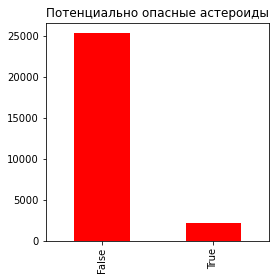

In [58]:
#Теперь посмотрим на количество опасных и не опасных астероидов и отобразим их на столбчатой диаграмме

fig_dang, ax = plt.subplots(1, 1, figsize=(4, 4))

(df_groupped['Гиппотетич. опасность'].value_counts()).plot(kind='bar', color = 'red');

ax.set_title('Потенциально опасные астероиды')

print(df_groupped['Гиппотетич. опасность'].value_counts())

Построим круговую диаграмму для данного соотношения

In [59]:
dang = df_groupped['Гиппотетич. опасность'].value_counts('True')
dang

False    0.92076
True     0.07924
Name: Гиппотетич. опасность, dtype: float64

Text(0.5, 1.0, 'Соотношение опасных и неопасных для Земли ближайших астероидов')

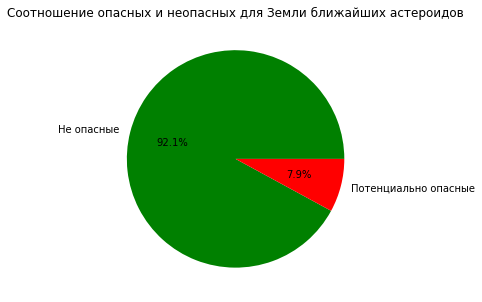

In [60]:
diag_dang, ax = plt.subplots(1, 1, figsize=(5, 5))

plt.pie(dang, labels = ['Не опасные', 'Потенциально опасные'], colors = ['green', 'red'], autopct = '%.1f%%');

ax.set_title('Соотношение опасных и неопасных для Земли ближайших астероидов')

На величину кинетической энергии влияет масса и скорость. Масса астероида, если и изменяется в космосе, то в основном за счет взаимодействия с другими телами и изменения эти, как правило не столь значительны по сравнению с изменением скорости. К тому же скорость влияет на кинетическую энергию больше, чем масса, т. к. она в формуле имеет степень 2, а масса 1. Скорость астероида может изменяться за счет гравитационного взаимодействия с другими телами. 

Предположим, что чем больше масса астероида, тем большую скорость он может иметь. Построим график зависимости скорости от массы и проверим нашу гипотезу.

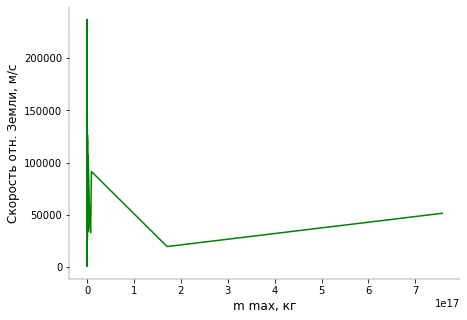

In [61]:
import matplotlib.pyplot as plt

df_groupped = df_groupped.sort_values('m max, кг')

fig_vm, ax = plt.subplots(1,1, figsize=(7,5)) 

ax.plot(df_groupped['m max, кг'], df_groupped['Скорость отн. Земли, м/с'], color = 'green')

ax.set_xlabel('m max, кг', fontsize=12)
ax.set_ylabel('Скорость отн. Земли, м/с', fontsize=12)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for spine in ['bottom','left']:
    ax.spines[spine].set_linewidth(0.3)

По полученному графику сложно говорить о существовании какой-либо зависимости. Мы видим, что действительно, астероиды с большей массой могут иметь большую скорость, но это справедливо не для всех граничных условий на нашем графике. 

Известно, сила гравитационного взаимодействия действительно зависит от масс обоих тел, которые взаимодействуют друг с другом, и чем эти массы больше, тем соответственно, больше и сила, а значит и придаваемое ускорение. Тем не менее,  некоторые астероиды из нашего Dataset могли пролетать рядом с другими более массивными телами, получая дополнительное ускорение, а другие могли этого не делать. Поэтому установить зависимость скорости астероида от массы без учета других факторов не получится.

Из данного раздела можно сделать 2 вывода:

1) Кинетическая энергия потенциально опасных астероидов чаще всего выше

2) Потенциально опасные астероиды чаще всего располагаются к нам ближе

<div id= 'id_2'/>

# Проверка возможности наблюдать за опасными астероидами через любительский телескоп

На сегодняшний день любительские телескопы позволяют увидеть объекты находящиеся на расстоянии от Земли порядка 150 млн км и увидеть ближайшие соседние галактики. Поэтому можно с определенной долей уверенности утверждать, что через любительские телескопы возможно наблюдать ближайшие астероиды. Тем не менее для того, чтобы в этом убедиться проверим статистику значений расстояний от Земли до них, и проверим есть ли в нашем Dataset значения превышающие 150 млн км.

In [62]:
observe = df_groupped.loc[df_groupped['Гиппотетич. опасность'] == True]
observe['Расстояние до Земли, км'].describe()

count    2.173000e+03
mean     3.584746e+07
std      1.438354e+07
min      8.321449e+05
25%      2.720135e+07
50%      3.803398e+07
75%      4.538940e+07
max      7.470231e+07
Name: Расстояние до Земли, км, dtype: float64

Как мы видим максимальное расстояние до астероида относящегося к ближайшим к Земле составляет приблизительно 74,7 млн км. Наблюдать такие тела через любительский телескоп может быть достаточно затруднительно, но теоретически возможно. При этом легче всего будет заметить небесное тело с меньшим значением видимой яркости или видимой звездной величины (Солнце имеет отрицательную видимую яркость, астероиды положительную).

<img src="img/apparent_magnitude.jpg">

Для того чтобы определить за какими опасными астероидами будет проще наблюдать при идеальных погодных условиях, отсортируем наш DataFrame по столбцу 'Видимая яркость' по возрастанию.

In [63]:
observe = observe.sort_values('Видимая яркость')
observe.head(10)

,Гиппотетич. опасность,"Малая ось, км","Большая ось, км","Скорость отн. Земли, м/с","Расстояние до Земли, км",Видимая яркость,"V, м^3","m min, кг","m max, кг","Eк max, Дж","S пов-ти, м^2","v1, м/с",Возможность высадки аппарата
Название,,,,,,,,,,,,,
3122 Florence (1981 ET3),True,4.135757,9.247833,59047.249731,2.887786e+07,14.04,1.851968e+11,2.555716e+14,9.852472e+14,1.717570e+24,1.012339e+08,953.793134,True
4183 Cuno (1959 LM),True,3.967848,8.872377,79401.731783,4.110363e+07,14.13,1.635436e+11,2.256902e+14,8.700520e+14,2.742680e+24,9.318070e+07,896.301641,True
3200 Phaethon (1983 TB),True,3.503926,7.835018,117420.653140,2.952194e+07,14.40,1.126247e+11,1.554221e+14,5.991633e+14,4.130515e+24,7.266511e+07,186.833260,True
16960 (1998 QS52),True,3.439973,7.692012,126572.996861,4.636098e+07,14.44,1.065697e+11,1.470661e+14,5.669506e+14,4.541479e+24,7.003674e+07,316.558655,True
242450 (2004 QY2),True,2.954983,6.607543,95485.881367,5.530231e+07,14.77,6.755128e+10,9.322076e+13,3.593728e+14,1.638300e+24,5.168041e+07,155.043724,True
89830 (2002 CE),True,2.682594,5.998463,102763.547415,6.729909e+07,14.98,5.053980e+10,6.974493e+13,2.688718e+14,1.419689e+24,4.259180e+07,238.481224,True
4953 (1990 MU),True,2.633631,5.888979,90988.286143,4.449855e+07,15.02,4.782264e+10,6.599524e+13,2.544165e+14,1.053140e+24,4.105121e+07,113.619845,True
137427 (1999 TF211),True,2.457848,5.495915,105547.369460,6.216949e+07,15.17,3.887170e+10,5.364295e+13,2.067975e+14,1.151887e+24,3.575411e+07,311.497232,True
1981 Midas (1973 EA),True,2.401900,5.370812,100008.996748,3.497711e+07,15.22,3.627718e+10,5.006251e+13,1.929946e+14,9.651467e+23,3.414491e+07,289.370458,True


Невооруженным глазом можно увидеть объекты на небе со значением видимой яркости менее 7.0. Как видно из нашего отсортированного DataFrame, такие значения отсутствуют.

Возможность наблюдать объекты различной видимой яркости через любительский телескоп зависит от диаметра окуляра. Самый большой диаметр окуляра любительских телескопов составляет 508 мм. Через него можно наблюдать объекты с видимой яркостью менее 16.4. Найдем такие значения в нашем DataFrame.

<img src="img/telescope.jpg">

In [64]:
observe = observe[observe['Видимая яркость'] - 16.4 <= 0]
observe.head(10)

,Гиппотетич. опасность,"Малая ось, км","Большая ось, км","Скорость отн. Земли, м/с","Расстояние до Земли, км",Видимая яркость,"V, м^3","m min, кг","m max, кг","Eк max, Дж","S пов-ти, м^2","v1, м/с",Возможность высадки аппарата
Название,,,,,,,,,,,,,
3122 Florence (1981 ET3),True,4.135757,9.247833,59047.249731,2.887786e+07,14.04,1.851968e+11,2.555716e+14,9.852472e+14,1.717570e+24,1.012339e+08,953.793134,True
4183 Cuno (1959 LM),True,3.967848,8.872377,79401.731783,4.110363e+07,14.13,1.635436e+11,2.256902e+14,8.700520e+14,2.742680e+24,9.318070e+07,896.301641,True
3200 Phaethon (1983 TB),True,3.503926,7.835018,117420.653140,2.952194e+07,14.40,1.126247e+11,1.554221e+14,5.991633e+14,4.130515e+24,7.266511e+07,186.833260,True
16960 (1998 QS52),True,3.439973,7.692012,126572.996861,4.636098e+07,14.44,1.065697e+11,1.470661e+14,5.669506e+14,4.541479e+24,7.003674e+07,316.558655,True
242450 (2004 QY2),True,2.954983,6.607543,95485.881367,5.530231e+07,14.77,6.755128e+10,9.322076e+13,3.593728e+14,1.638300e+24,5.168041e+07,155.043724,True
89830 (2002 CE),True,2.682594,5.998463,102763.547415,6.729909e+07,14.98,5.053980e+10,6.974493e+13,2.688718e+14,1.419689e+24,4.259180e+07,238.481224,True
4953 (1990 MU),True,2.633631,5.888979,90988.286143,4.449855e+07,15.02,4.782264e+10,6.599524e+13,2.544165e+14,1.053140e+24,4.105121e+07,113.619845,True
137427 (1999 TF211),True,2.457848,5.495915,105547.369460,6.216949e+07,15.17,3.887170e+10,5.364295e+13,2.067975e+14,1.151887e+24,3.575411e+07,311.497232,True
1981 Midas (1973 EA),True,2.401900,5.370812,100008.996748,3.497711e+07,15.22,3.627718e+10,5.006251e+13,1.929946e+14,9.651467e+23,3.414491e+07,289.370458,True


In [65]:
#Проверим количество опасных астероидов, которые можно наблюдать через любительский телескоп.
len(observe)

42

In [66]:
#Найдем долю опасных астероидов, которые можно наблюдать через любительский телескоп с диаметром окуляра 508 мм
obs_part = round(len(observe)/len(df_groupped.loc[df_groupped['Гиппотетич. опасность'] == True]) * 100, 2)
print(obs_part, '%', sep = '')

1.93%


Построим график зависимости видимой яркости от объема астероида. Очевидно, что на видимую яркость влияет не только размер космического тела, но и в первую очередь его химический состав. Тем не менее, в связи с отсутствием таких данных, а также с учетом того, что видимая яркость различных астероидов зачастую схожа, при помощи построения такого графика мы сможем определить степень влияния объема тела на возможность его увидеть. Если будет наблюдаться явная зависимость, значит можно сделать вывод, что объем влияет на видимую яркость. Если зависимость наблюдаться не будет, значит без учета хим. состава астероида однозначный вывод сделать невозможно.

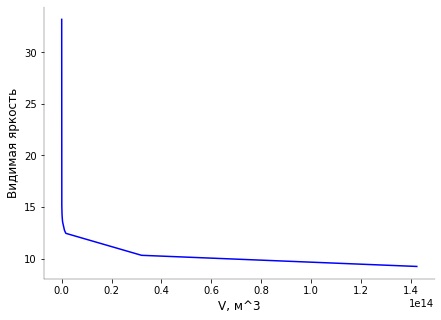

In [67]:
fig_vis, ax = plt.subplots(1,1, figsize=(7,5)) 

ax.plot(df_groupped['V, м^3'], df_groupped['Видимая яркость'], color = 'blue')

ax.set_xlabel('V, м^3', fontsize=12)
ax.set_ylabel('Видимая яркость', fontsize=12)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for spine in ['bottom','left']:
    ax.spines[spine].set_linewidth(0.3)

Получили график похожий на кривую гиперболы. Можем заметить, при начальном увеличении объема от нуля, значение видимой светимости падает существенно, затем при значительном увеличении объема падение светимости не такое резкое и постепенно приближается к нулю. Что позволяет нам выдвинуть гипотезу о том, что астероиды из нашего Dataset, хоть и отличаются между собой по химическому составу, но тем не менее сам материал, из которого они состоят имеет близкие по значению отражательные способности.

Для звезд должен получиться похожий график, однако, он будет располагаться под осью X (НЕ отраженный зеркально), т.к. они имеют отрицательные значения видимой яркости, а также вертикальная асимптотата не будет совпадать с осью Y, как для астероидов, т. к. для рождение звезды требуется определенное минимальное количество массы материи, а следовательно и его объема.

Стоит отметить, что график не является идеальной гиперболой, т. к. он построен по данным, полученным из теоретических расчетов по империческим значениям.

<div id= 'id_3'/>

# Расчет максимально возможной скорости исследовательского аппарата на поверхности астерода

Из нашего DataFrame наиболее интересными для научного исследовани могут быть астероиды с наибольшей площадью поверхности, если не брать в расчет другие фаторы, не указанные в исходной таблице.

Для расчета воспользуемся формулой: $$S_{пов-ти} = 2\pi a(a + \frac{b^2}{\sqrt{b^2 - a^2}})arcsin(\frac{\sqrt{b^2 - a^2}}{b})$$

In [68]:
#при расчете учитываем, что км^2 необходимо перевести в м^2

b = np.array(df_groupped['Большая ось, км']) / 2
a = np.array(df_groupped['Малая ось, км']) / 2
sq = np.sqrt((b ** 2 - a ** 2))
df_groupped['S пов-ти, м^2'] = (2 * pi * a * (a + ((b ** 2) / sq) * np.arcsin(sq / b))) * (1000 ** 2)
df_groupped = df_groupped.sort_values('S пов-ти, м^2', ascending = False)

Для того, чтобы исследовательский аппарат не оторвался от поверхности астероида, улетев при этом в космос или став его спутником, необходимо, чтобы его скорость перемещения по поверхности не превышала первую космическую. Для расчета воспользуемся формулой: $$v_{1} = \sqrt{G \frac{m}{R}},$$ где $G = 6.67430 \cdot{10 ^{-11}} Н \cdot{м^2} \cdot{кг^{-2}}$ 

m - масса астероида, 

R - расстояние от центра астероида до тела на его поверхности

Найдем первую космическую скорость для наших астероидов и оценим возможность пребывания на них аппаратов. Для расчета будем брать значение минимальной массы астероида, которую мы до этого посчитали. Это необходимо для того, чтобы лишний раз перестраховаться и задать исследовательскому аппарату скорость, с которой он гарантированно останется на поверхности.

Из этих же соображений в качестве расстояния от центра астероида до тела на поверхности возьмем большую полуось нашего эллипсоида.

In [69]:
df_groupped['v1, м/с'] = np.sqrt((6.67430 * (10 ** (-11)) * np.array(df_groupped['m min, кг'])) / b)

In [70]:
df_groupped['v1, м/с'].describe()

count     27423.000000
mean         26.647616
std         933.337274
min           0.000036
25%           0.115200
50%           0.743797
75%           6.045806
max      138820.688547
Name: v1, м/с, dtype: float64

Из полученной статистики можем заметить, что в выборке присутствуют как астероиды, на высадка на которые возможна, так и те, на которые "приземлиться" не получится из-за очень низкой гравитации.

В рамках проекта будем считать, что наш аппарат планирует перемещаться по астероиду со скоростью 5 км/ч или 1,4 м/с. Заложим небольшой запас на эту скорость, чтобы учесть некоторые непредвиденные обстоятельства, такие, как слечайный отрыв колес от поверхности и др. Будем считать, что мы можем высдать аппарат на астероиды, первая космическая скорость на котором равна 5 м/с, и проверим на скольких из них теоретически возможно проводить какие-либо исследования.

In [71]:
df_groupped['Возможность высадки аппарата'] = np.where(df_groupped['v1, м/с'] >= 5, True, False)

In [72]:
df_groupped['Возможность высадки аппарата'].value_counts()

False    19920
True      7503
Name: Возможность высадки аппарата, dtype: int64

False    19920
True      7503
Name: Возможность высадки аппарата, dtype: int64


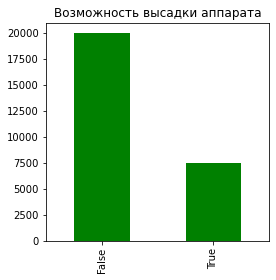

In [73]:
fig_land, ax = plt.subplots(1, 1, figsize=(4, 4))

(df_groupped['Возможность высадки аппарата'].value_counts()).plot(kind='bar', color = 'green');

ax.set_title('Возможность высадки аппарата')

print(df_groupped['Возможность высадки аппарата'].value_counts())

In [74]:
#найдем долю астероидов, на которые можно высадить аппарат
landing = df_groupped['Возможность высадки аппарата'].value_counts('True')
print(landing)

False    0.726398
True     0.273602
Name: Возможность высадки аппарата, dtype: float64


Text(0.5, 1.0, 'Кол-во ближайших астероидов, на которые возможна высадка аппарата')

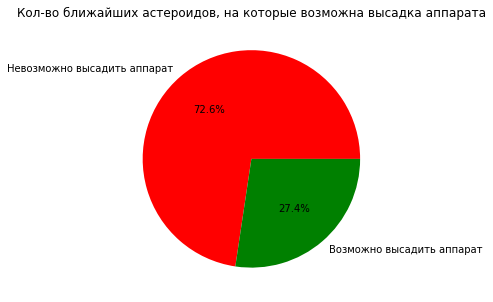

In [75]:
diag_land, ax = plt.subplots(1, 1, figsize=(5, 5))

plt.pie(landing, labels = ['Невозможно высадить аппарат', 'Возможно высадить аппарат'], colors = ['red', 'green'], autopct = '%.1f%%');

ax.set_title('Кол-во ближайших астероидов, на которые возможна высадка аппарата')

Из формулы для нахождения первой космической скорости очевидно, что высадка аппарата будет возможна лишь на самых крупных объектах. Найдем в нашем DataFrame объекты с минимальной массой, на которые можно спустить аппарат.

In [76]:
mass_min = round(df_groupped.loc[df_groupped['Возможность высадки аппарата'] == True]['m min, кг'].min())
print(mass_min, 'кг')

9765908323 кг


<div id = 'id_4'\>
    
# Выводы

### Общая информация по всем астероидам из Dataset

In [77]:
#DataFrame отсортирован по убыванию площади поверхности астероида
df_groupped.head(30)

,Гиппотетич. опасность,"Малая ось, км","Большая ось, км","Скорость отн. Земли, м/с","Расстояние до Земли, км",Видимая яркость,"V, м^3","m min, кг","m max, кг","Eк max, Дж","S пов-ти, м^2","v1, м/с",Возможность высадки аппарата
Название,,,,,,,,,,,,,
1036 Ganymed (A924 UB),False,37.892650,84.730541,51496.923293,5.372124e+07,9.23,1.424405e+14,1.965679e+17,7.577836e+17,1.004796e+27,8.498180e+09,138820.688547,True
433 Eros (A898 PA),False,23.043847,51.527608,19682.887099,3.754117e+07,10.31,3.203565e+13,4.420920e+16,1.704297e+17,3.301359e+25,3.142867e+09,62151.868483,True
1866 Sisyphus (1972 XA),False,8.640820,19.321462,91462.394087,7.070096e+07,12.44,1.689015e+12,2.330841e+15,8.985561e+15,3.758377e+25,4.419020e+08,13045.303659,True
4954 Eric (1990 SQ),False,8.101305,18.115068,32852.598792,4.286086e+07,12.58,1.391982e+12,1.920935e+15,7.405343e+15,3.996268e+24,3.884418e+08,11154.604925,True
1627 Ivar (1929 SH),False,7.456843,16.674007,37715.974055,4.529595e+07,12.76,1.085509e+12,1.498003e+15,5.774910e+15,4.107389e+24,3.290985e+08,9407.065954,True
2212 Hephaistos (1978 SB),False,5.230642,11.696071,107246.722929,5.921903e+07,13.53,3.746567e+11,5.170263e+14,1.993174e+15,1.146260e+25,1.619295e+08,5526.551087,True
25916 (2001 CP44),False,4.704950,10.520587,36240.023183,6.211572e+07,13.76,2.726676e+11,3.762813e+14,1.450592e+15,9.525595e+23,1.310165e+08,4607.381687,True
1980 Tezcatlipoca (1950 LA),False,4.619075,10.328565,50104.592172,4.942800e+07,13.80,2.580082e+11,3.560514e+14,1.372604e+15,1.722940e+24,1.262775e+08,4481.817745,True
5587 (1990 SB),False,4.576727,10.233872,33670.778719,4.835921e+07,13.82,2.509768e+11,3.463480e+14,1.335197e+15,7.568704e+23,1.239727e+08,4260.437441,True


### Статистические данные

#### Количество опасных и неопасных астероидов среди ближайших

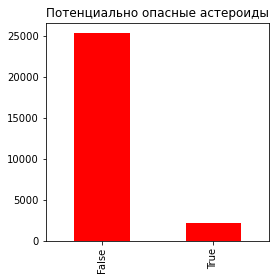

In [78]:
fig_dang

In [79]:
print(df_groupped['Гиппотетич. опасность'].value_counts())

False    25250
True      2173
Name: Гиппотетич. опасность, dtype: int64


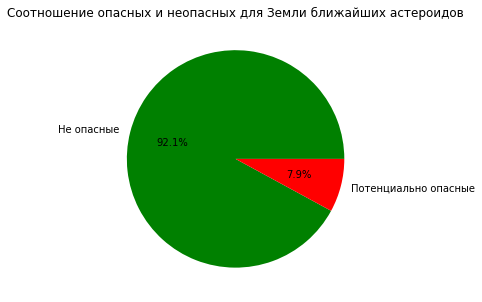

In [80]:
diag_dang

#### Ближайшие астероиды, на которые можно высадить исследовательский аппарат

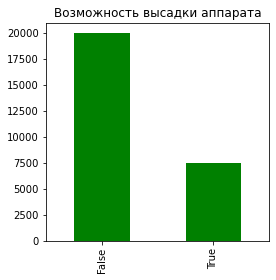

In [81]:
fig_land

In [82]:
print(df_groupped['Возможность высадки аппарата'].value_counts())

False    19920
True      7503
Name: Возможность высадки аппарата, dtype: int64


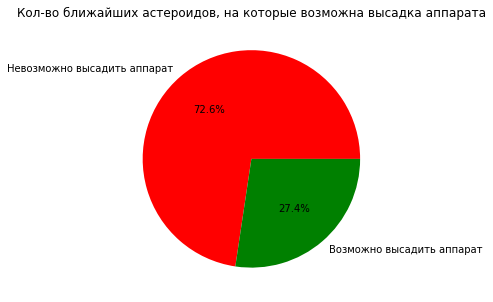

In [83]:
diag_land

#### Минимальная масса астероида, на который можно высадить, исследовательский аппарат

In [84]:
print(mass_min, 'кг')

9765908323 кг


В ходе разведывательного анализа данных было установлено, что на степень опасности астероида в случае его гипотетического столкновения с Землей, в большей степени влияет его кинетическая энергия. А также установлено, что астероиды, имеющие статус потенциально опасных, располагаются к Земле ближе.

### Опасные астероиды, за которыми можно наблюдать через любительский телескоп

In [85]:
observe

,Гиппотетич. опасность,"Малая ось, км","Большая ось, км","Скорость отн. Земли, м/с","Расстояние до Земли, км",Видимая яркость,"V, м^3","m min, кг","m max, кг","Eк max, Дж","S пов-ти, м^2","v1, м/с",Возможность высадки аппарата
Название,,,,,,,,,,,,,
3122 Florence (1981 ET3),True,4.135757,9.247833,59047.249731,2.887786e+07,14.04,1.851968e+11,2.555716e+14,9.852472e+14,1.717570e+24,1.012339e+08,953.793134,True
4183 Cuno (1959 LM),True,3.967848,8.872377,79401.731783,4.110363e+07,14.13,1.635436e+11,2.256902e+14,8.700520e+14,2.742680e+24,9.318070e+07,896.301641,True
3200 Phaethon (1983 TB),True,3.503926,7.835018,117420.653140,2.952194e+07,14.40,1.126247e+11,1.554221e+14,5.991633e+14,4.130515e+24,7.266511e+07,186.833260,True
16960 (1998 QS52),True,3.439973,7.692012,126572.996861,4.636098e+07,14.44,1.065697e+11,1.470661e+14,5.669506e+14,4.541479e+24,7.003674e+07,316.558655,True
242450 (2004 QY2),True,2.954983,6.607543,95485.881367,5.530231e+07,14.77,6.755128e+10,9.322076e+13,3.593728e+14,1.638300e+24,5.168041e+07,155.043724,True
89830 (2002 CE),True,2.682594,5.998463,102763.547415,6.729909e+07,14.98,5.053980e+10,6.974493e+13,2.688718e+14,1.419689e+24,4.259180e+07,238.481224,True
4953 (1990 MU),True,2.633631,5.888979,90988.286143,4.449855e+07,15.02,4.782264e+10,6.599524e+13,2.544165e+14,1.053140e+24,4.105121e+07,113.619845,True
137427 (1999 TF211),True,2.457848,5.495915,105547.369460,6.216949e+07,15.17,3.887170e+10,5.364295e+13,2.067975e+14,1.151887e+24,3.575411e+07,311.497232,True
1981 Midas (1973 EA),True,2.401900,5.370812,100008.996748,3.497711e+07,15.22,3.627718e+10,5.006251e+13,1.929946e+14,9.651467e+23,3.414491e+07,289.370458,True


#### Зависимость видимой яркости от объема астероида

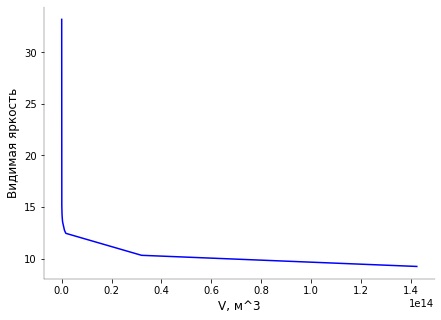

In [86]:
fig_vis

#### Доля опасных астероидов, за которым можно наблюдать через любительский телескоп с диаметром окуляра 508 мм

In [87]:
print(obs_part, '%', sep = '')

1.93%


#### Сохраним некоторые полученные данные в файлы

In [88]:
#DataFrame будем сохранять в 2 формата: '.pkl' и '.xlsx'.

df_groupped.to_pickle('Общая_информация_по_ближайшим_астероидам.pkl')
df_groupped.to_excel('Общая_информация_по_ближайшим_астероидам.xlsx', index = False)

observe.to_pickle('Опасные_астероиды_для_наблюдения_в_телескоп.pkl')
observe.to_excel('Опасные_астероиды_для_наблюдения_в_телескоп.xlsx', index = False)

fig_dang.savefig("Потенциально_опасные_астероиды_столбчатая_диаграмма.jpeg")
diag_dang.savefig("Потенциально_опасные_астероиды_круговая_диаграмма.jpeg")
fig_land.savefig("Возможность_высадки_аппарата_столбчатая_диаграмма.jpeg")
diag_land.savefig("Возможность_высадки_аппарата_круговая_диаграмма.jpeg")
fig_vis.savefig("Зависимость видимой яркости от объема астероида.jpeg")